In [10]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(cowplot)
library(CellChat)

panmerge<-readRDS(file="/home/liusong/scRNA/endometriosis/V2data/SpatialTranscriptome/Seurat/EMS_3sample_ST_merge_analysis_bySCT.rds")
GSYOMA<-subset(panmerge,orig.ident=="GSY")

Warning message:
"Not validating Seurat objects"
Warning message:
"Not validating Seurat objects"
Warning message:
"Not validating Seurat objects"


In [11]:
data.input<-Seurat::GetAssayData(GSYOMA,slot="data",assay="SCT")
meta<-data.frame(labels=Idents(GSYOMA),row.names=names(Idents(GSYOMA)))
unique(meta$labels)
spatial.locs<-Seurat::GetTissueCoordinates(GSYOMA,scale=NULL,cols=c("imagerow","imagecol"))
scale.factors = jsonlite::fromJSON(txt =file.path("/home/liusong/scRNA/endometriosis/V2data/SpatialTranscriptome/fastq/GSY_OMA/spatial",'scalefactors_json.json'))
scale.factors = list(spot.diameter = 65, spot = scale.factors$spot_diameter_fullres)

[1] Endo     OB       pericyte OM       OUn      OA       EC      
Levels: OB OA OM Endo EC pericyte OUn

In [12]:
dim(data.input)
head(meta)
dim(meta)
data.input[1:5,1:5]
head(spatial.locs)
dim(spatial.locs)


[1] 18042  2468

,labels
,<fct>
AACACTTGGCAAGGAA-1_1,Endo
AACAGGATTCATAGTT-1_1,OB
AACAGGTTATTGCACC-1_1,pericyte
AACAGGTTCACCGAAG-1_1,OB
AACAGTCAGGCTCCGC-1_1,OB
AACAGTCCACGCGGTG-1_1,OM


[1] 2468    1

5 x 5 sparse Matrix of class "dgCMatrix"
        AACACTTGGCAAGGAA-1_1 AACAGGATTCATAGTT-1_1 AACAGGTTATTGCACC-1_1
SAMD11             0.6931472            1.0986123            .        
NOC2L              .                    0.6931472            0.6931472
KLHL17             .                    .                    .        
PLEKHN1            .                    0.6931472            .        
PERM1              .                    .                    .        
        AACAGGTTCACCGAAG-1_1 AACAGTCAGGCTCCGC-1_1
SAMD11              .                   0.6931472
NOC2L               1.098612            .        
KLHL17              .                   .        
PLEKHN1             .                   .        
PERM1               .                   .        

,imagerow,imagecol
,<int>,<int>
AACACTTGGCAAGGAA-1_1,1219,2684
AACAGGATTCATAGTT-1_1,1264,2269
AACAGGTTATTGCACC-1_1,733,2912
AACAGGTTCACCGAAG-1_1,1316,2239
AACAGTCAGGCTCCGC-1_1,614,1731
AACAGTCCACGCGGTG-1_1,306,1794


[1] 2468    2

In [13]:
cellchat<-createCellChat(object=data.input,meta=meta,group.by="labels",datatype="spatial",coordinates=spatial.locs,scale.factors=scale.factors)

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial imaging data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  OB OA OM Endo EC pericyte OUn 


In [14]:
CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation")
cellchat@DB <- CellChatDB.use


In [15]:
cellchat <- subsetData(cellchat)
future::plan("multisession", workers =8)
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

In [16]:
cellchat <- computeCommunProb(cellchat,distance.use = TRUE,scale.distance = 0.01)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on spatial imaging data using distances as constraints <<< [2024-10-15 14:44:42.903054]"
The suggested minimum value of scaled distances is in [1,2], and the calculated value here is  1.83907 
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-10-15 16:31:19.420676]"


In [17]:
cellchat <- filterCommunication(cellchat, min.cells = 10)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)
str(cellchat@net)


List of 4
 $ prob  : num [1:7, 1:7, 1:788] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:788] "TGFB1_TGFBR1_TGFBR2" "TGFB2_TGFBR1_TGFBR2" "TGFB3_TGFBR1_TGFBR2" "TGFB1_ACVR1B_TGFBR2" ...
 $ pval  : num [1:7, 1:7, 1:788] 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:788] "TGFB1_TGFBR1_TGFBR2" "TGFB2_TGFBR1_TGFBR2" "TGFB3_TGFBR1_TGFBR2" "TGFB1_ACVR1B_TGFBR2" ...
 $ count : num [1:7, 1:7] 52 71 34 36 65 41 17 66 78 46 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
 $ weight: num [1:7, 1:7] 0.861 0.253 0.327 0.13 0.603 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...
  .. ..$ : chr [1:7] "OB" "OA" "OM" "Endo" ...


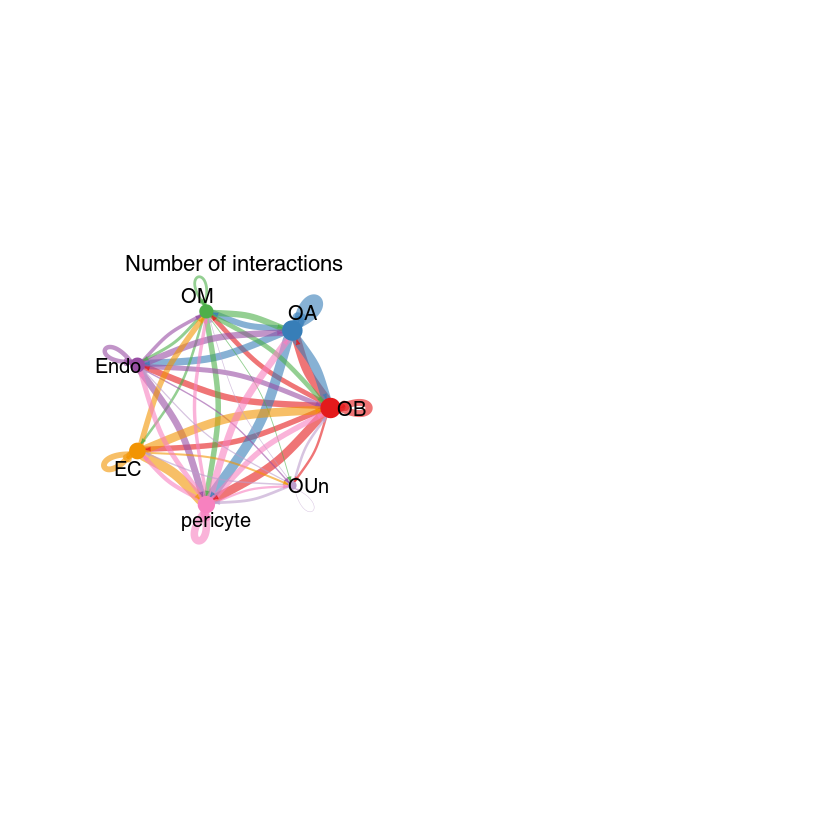

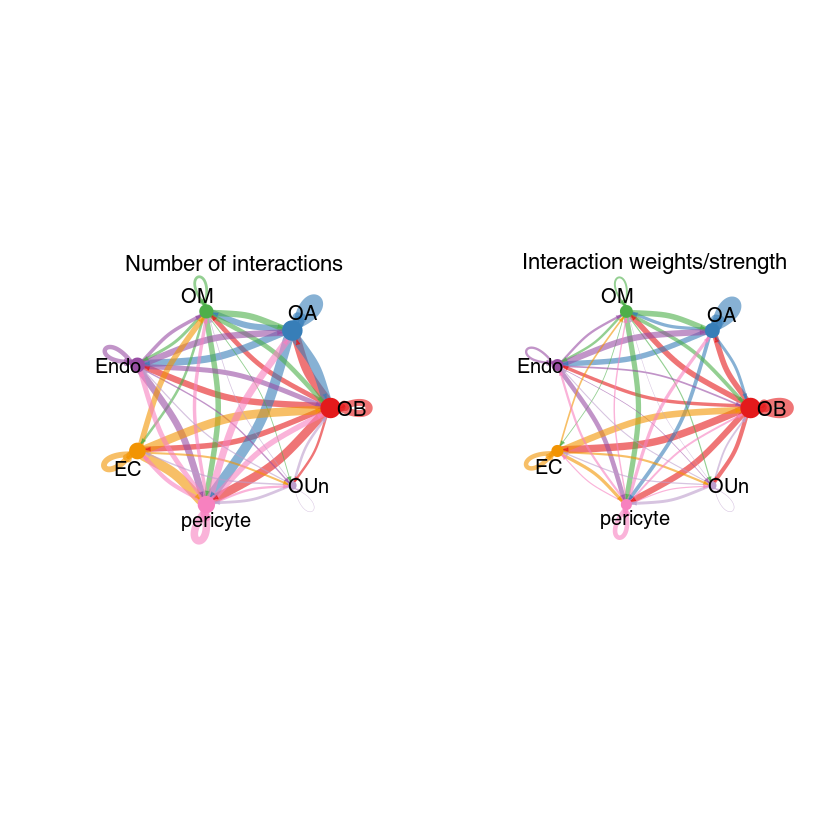

Do heatmap based on a single object 


Do heatmap based on a single object 




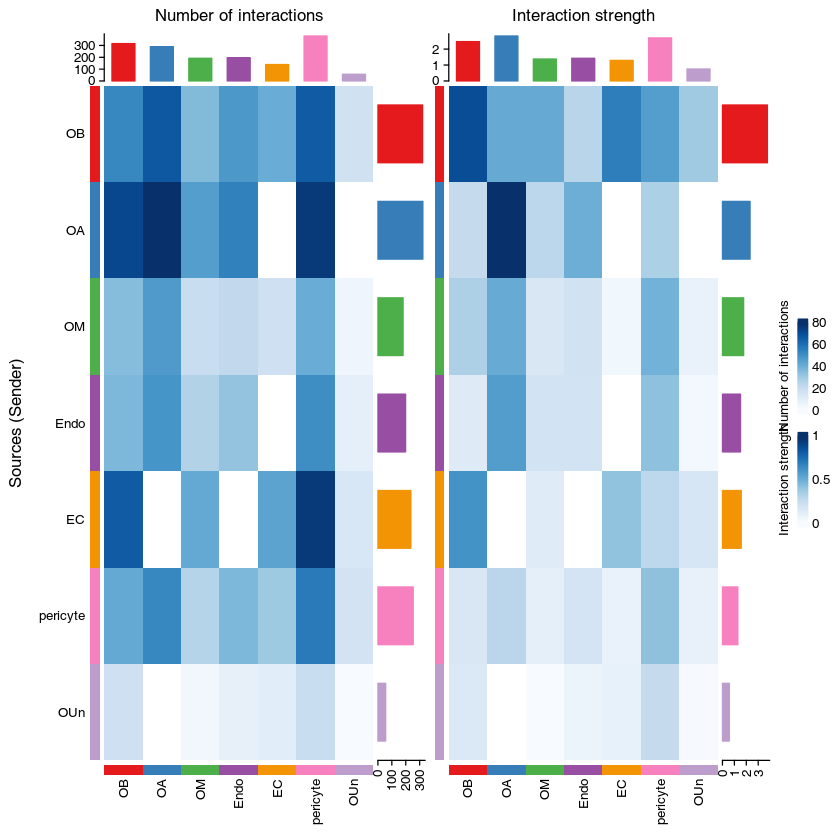

In [18]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = rowSums(cellchat@net$count),weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = rowSums(cellchat@net$weight),weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
p1 <- netVisual_heatmap(cellchat, measure = "count", color.heatmap = "Blues")
p2 <- netVisual_heatmap(cellchat, measure = "weight", color.heatmap = "Blues")
p1 + p2

In [32]:
cellchat<-updateClusterLabels(cellchat,new.order=c("EC",'OB','OM','OA','pericyte','Endo','OUn'))
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways


ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing",height=15)
ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming",height=15)


Only reorder cell groups but do not rename cell groups!

Reorder cell groups! 



The cell group order before reordering is  EC OB OM OA pericyte Endo OUn 
The cell group order after reordering is  EC OB OM OA pericyte Endo OUn 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



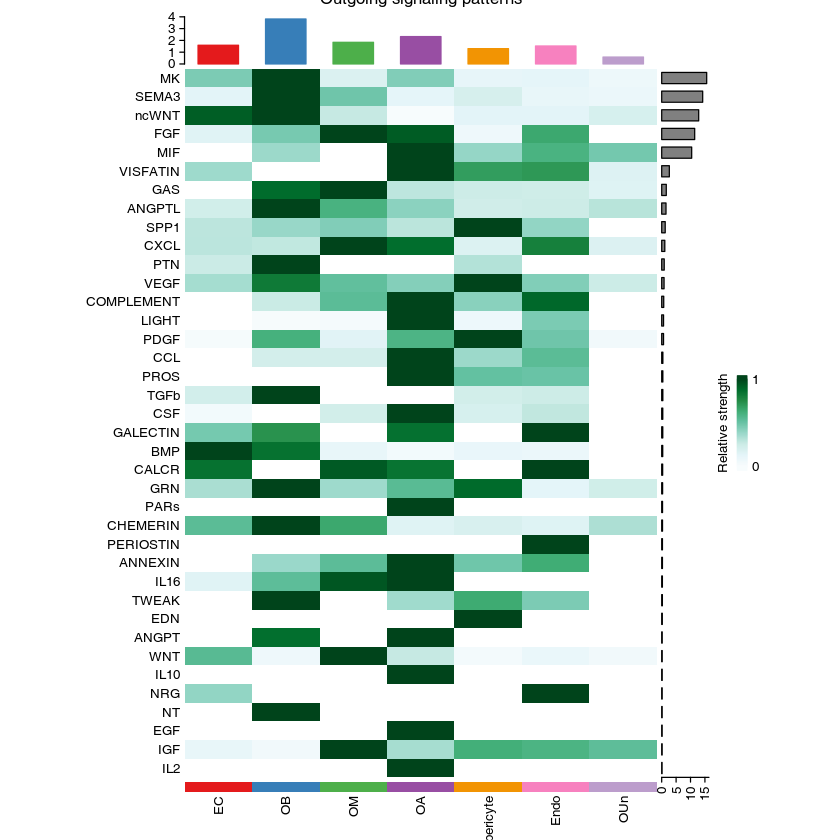

In [30]:
ht1

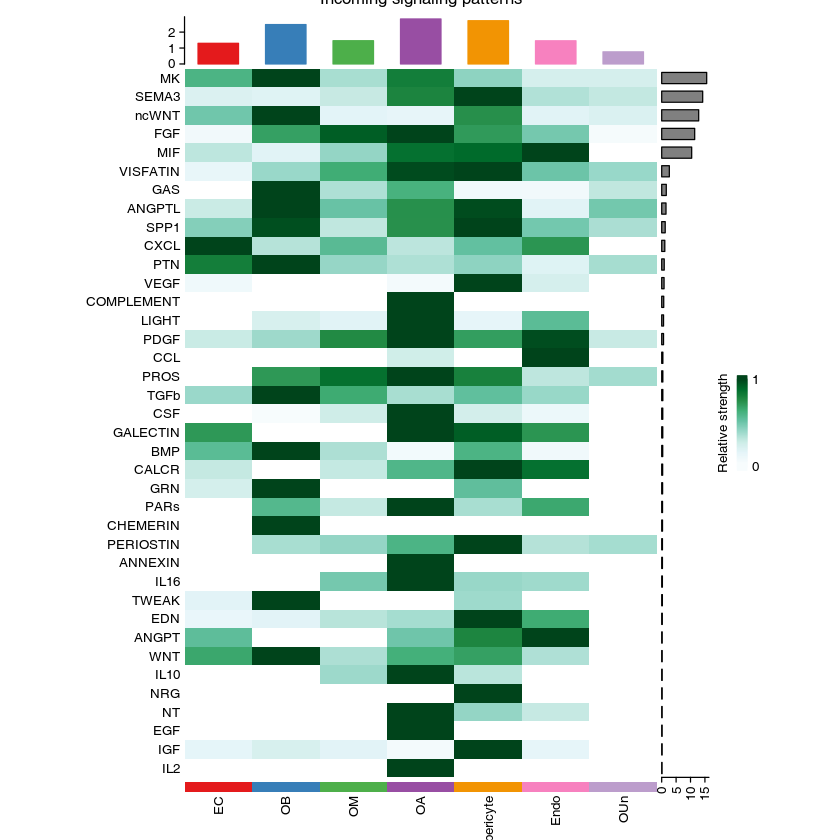

In [31]:
ht2

Comparing communications on a single object 




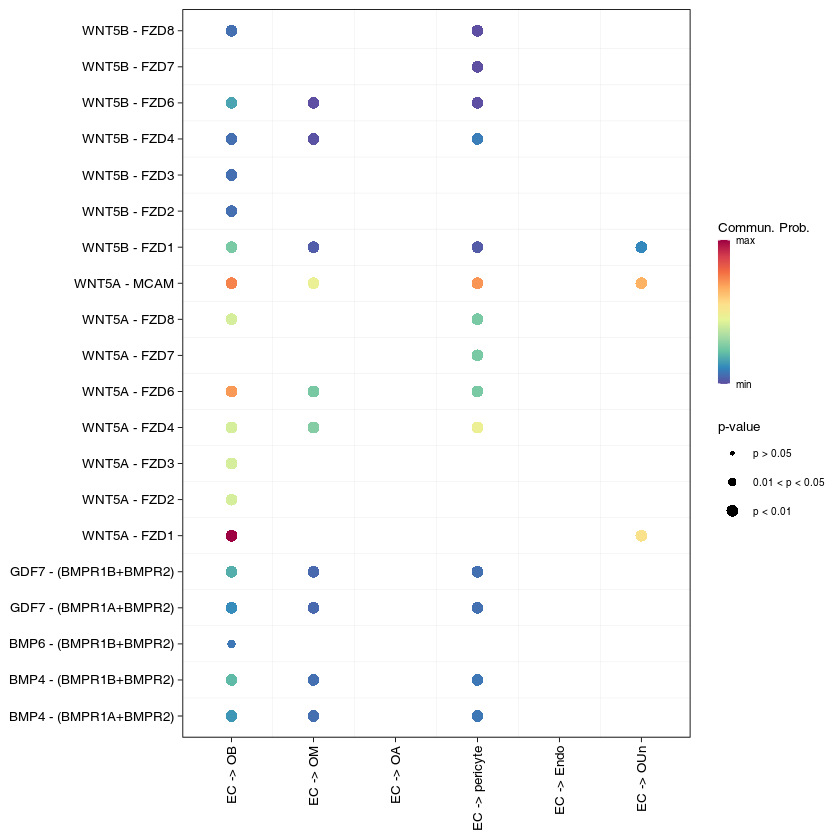

In [38]:
netVisual_bubble(cellchat, sources.use = 1,signaling = c("ncWNT","BMP"),targets.use = c(2:7))


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


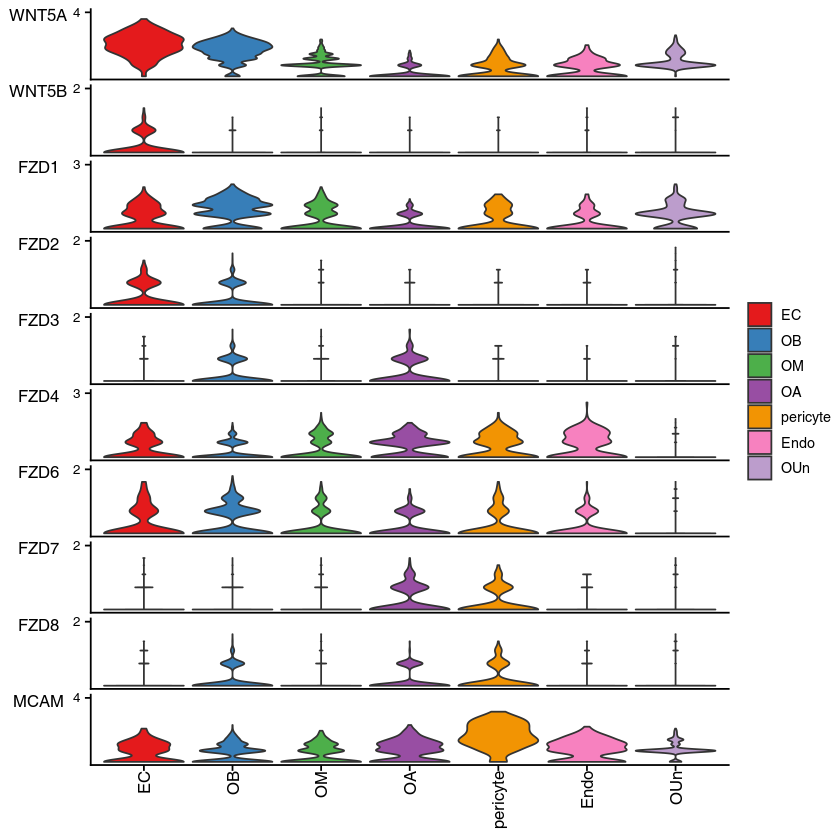

In [39]:
plotGeneExpression(cellchat, signaling = "ncWNT")
#saveRDS(cellchat, file = "STdata_GSY_cellchat.rds")